In [181]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_curve,confusion_matrix, matthews_corrcoef, accuracy_score, precision_score, recall_score

In [ ]:
def labeling(subset): #function that etiquettes the sequences if they are positive with a +, if negative with a -, building a binary list

    label=[] #list of 1 if the seq is + or 0 if the seq is neg

    subset['positive/negative'] =np.where(subset['SP cleavage']=='False', '-','+')
    for row,seq in subset.iterrows():
        if seq['positive/negative']=="+":
            label.append(1)
        else:
            label.append(0)
    return label

In [183]:
subset_list=['subset1_arricchito.tsv','subset2_arricchito.tsv','subset3_arricchito.tsv','subset4_arricchito.tsv','subset5_arricchito.tsv']
subset={}
for i in range(len(subset_list)):
    subset[f'subset_{i+1}']=pd.read_csv(subset_list[i],sep="\t")

In [184]:
list_labels=[]
subset_for_labels = {'subset_1':subset['subset_4'],'subset_2':subset['subset_5'],'subset_3':subset['subset_1'],'subset_4':subset['subset_2'],'subset_5':subset['subset_3']}
for df in subset_for_labels.values():
    etiq = labeling(df)
    list_labels.append(etiq)

In [185]:
def file_set_creator(subset_dict):
    training_list = []
    validation_list = []
    testing_list = []
    keys = list(subset_dict.keys())   # elenco delle chiavi: ["subset_1", ..., "subset_5"]
    n = len(keys)

    for i in range(n):
        # --- Training: 3 DataFrame
        training_keys = [keys[i % n], keys[(i+1) % n], keys[(i+2) % n]]
        training_dfs = [subset_dict[k] for k in training_keys]
        training = pd.concat(training_dfs, ignore_index=True)
        pos_seq = []

        positive_df = training[training['SP cleavage'] != 'False']
    
        for _, row in positive_df.iterrows():
            sequence = row["Sequence"]
            cleavage = int(row["SP cleavage"])
            # estraggo la porzione di interesse
            pos_seq.append(sequence[cleavage-13:cleavage+2])
        
        training_list.append(pos_seq)


        # --- Validation: 1 DataFrame
        validation_key = keys[(i+3) % n]
        validation = subset_dict[validation_key]
        seq_val_90=[]
        for index,row in validation.iterrows(): #metodo di Pandas per iterare 
            sequence=row["Sequence"]
            seq_val_90.append(sequence[:90])
        validation_list.append(seq_val_90)
        

        # --- Testing: 1 DataFrame
        testing_key = keys[(i+4) % n]
        testing = subset_dict[testing_key]
        seq_test_90=[]
        for index,row in testing.iterrows(): #metodo di Pandas per iterare 
            sequence=row["Sequence"]
            seq_test_90.append(sequence[:90])
        testing_list.append(seq_test_90)

        

    return training_list,validation_list,testing_list

In [186]:
trainingset,validationset,testingset = file_set_creator(subset)

In [187]:
for i in validationset:
    for seq in i:
        if len(seq) > 90:
            print(seq)

In [188]:
def init_matrix (window):
    aminoacids = ["A","R","N","D","C","Q","E","G","H","I",
              "L","K","M","F","P","S","T","W","Y","V"]
    dict_mat = {}
    for i in aminoacids:
        dict_mat[i]= [1 for i in range(window)]
    return dict_mat

In [189]:
def compute_pswm (matrix,list_seq):
    diz_swp = {'A':0.08, 'R':0.06, 'N':0.04, 'D':0.06, 'C':0.01, 'Q':0.04, 'E':0.07, 'G':0.07, 'H':0.02, 'I':0.06, 'L':0.10, 'K':0.06, 'M':0.02, 'F':0.04, 'P':0.05, 'S':0.07, 'T':0.05, 'W':0.01, 'Y':0.03, 'V':0.07}
    for seq in list_seq:
        for index,res in enumerate(seq):
          if res not in matrix:
              continue
          matrix[res][index]+=1
    
    div = int(len(list_seq))+20

    
    for key in matrix:
        matrix[key] = [np.log2(x/(div*diz_swp[key])) for x in matrix[key]]

    return matrix

In [190]:
def score_window(matrix, seq_window):
    score = 0
    for pos in range(len(seq_window)):
        letter = seq_window[pos]
        if letter in matrix:
            score += matrix[letter][pos]
    return score


In [191]:
def train_and_score(training,validation):
     global current_labels
     matrix = init_matrix(15)
     PSWM = compute_pswm(matrix,training)
     final_score=[]
     for seq in validation:#ricorda di farla come lista di seqeunze len = 90
          scores_seq = []
          if len(seq) < 15:
               continue
          for i in range(len(seq)-14):
               window = seq[i:15+i]
               score = score_window(PSWM,window)
               scores_seq.append(score)
          max_score = max(scores_seq)
          final_score.append(max_score)
     precision, recall, thresholds = precision_recall_curve(current_labels, final_score)
     fscore = (2 * precision * recall) / (precision + recall)
     index = np.argmax(fscore)
     optimal_threshold = thresholds[index]
     return PSWM, optimal_threshold

In [192]:
PSWM_matrix_final = {}
optimal_threshold = {}

for i in range(len(trainingset)):
    current_labels = list_labels[i]
    PSWM_matrix_final[f"PSWM_matrix{i}"], optimal_threshold[f"optimal_threshold{i}"] = train_and_score(trainingset[i], validationset[i])

W = PSWM_matrix_final['PSWM_matrix0']
Th = optimal_threshold['optimal_threshold0']


In [193]:
print(optimal_threshold)

{'optimal_threshold0': 9.783363992057446, 'optimal_threshold1': 9.81140452011514, 'optimal_threshold2': 9.427456848485326, 'optimal_threshold3': 9.939036452548477, 'optimal_threshold4': 9.8901641136577}


In [194]:
print(PSWM_matrix_final)


{'PSWM_matrix0': {'A': [0.2816642246736351, 0.5310236936103524, 0.10833262178807318, 0.33510348363509546, 0.9966872659591642, 1.2541834882515281, 0.33510348363509546, 0.9631347062481377, 0.6412066113607754, 0.16845361422564425, 1.7136151068888255, 0.3086312722739044, 2.6358928114643074, 0.9800085248125339, -0.7458165117484719], 'R': [-2.2238638085531157, -5.03121873061072, -4.03121873061072, -2.7092906357233577, -3.446256229889564, -3.446256229889564, -2.2238638085531157, -3.03121873061072, -1.446256229889564, -1.1243281350022014, -3.03121873061072, -0.031218730610720058, -3.03121873061072, -0.5717871119734227, -0.07702242022384478], 'N': [-4.446256229889564, -2.8612937291684077, -3.4462562298895643, -3.4462562298895643, -1.8612937291684077, -2.8612937291684077, -2.1243281350022016, -2.8612937291684077, -0.8612937291684077, -1.8612937291684077, -2.1243281350022016, -0.9868246112522668, -3.4462562298895643, -0.6389013078319601, -0.3587933886392246], 'D': [-2.7092906357233577, -4.0312187

In [195]:
def testing(matrix, th, testing_set):
    """
    Calcola lo score massimo (su finestre di lunghezza 15) per ogni sequenza del set di test.
    Ritorna una lista di score, uno per sequenza.
    """
    final_score = []
    for seq in testing_set:  # lista di sequenze (ognuna lunga ~90 aa)
        if len(seq) < 15:
            continue
        scores_seq = []
        for i in range(len(seq) - 14):
            window = seq[i:i+15]
            score = score_window(matrix, window)
            scores_seq.append(score)
        max_score = max(scores_seq)
        final_score.append(max_score)
    y_pred_test = [int(s >= th) for s in final_score]
    return final_score, y_pred_test


In [196]:
Th = optimal_threshold['optimal_threshold0']
matrix_try = PSWM_matrix_final['PSWM_matrix0']
ok,po = testing(matrix_try,Th,testingset[i])
print(ok)
print(po)

[11.064441245058365, 12.620188396283586, 6.2130826092475635, 14.504066172781556, 16.09772858217739, 8.646689430868754, 11.807293591858492, 9.701479123643372, 10.758912622894897, 5.34549957008821, 14.516296799358097, 13.866513255942596, 7.060811007988756, 13.531076451739244, 13.198374614967978, 4.238616423112089, 12.874760341789385, 10.94863338931425, 5.279405207862557, 12.885374728567468, 13.676072621894562, 8.395894732698109, 9.464735847181347, 12.552540134152038, 14.851897265104231, 8.280126353350413, 13.360963424781358, 11.536202957878983, 7.426665874172575, 6.835031834035732, 17.229880289723372, 8.94685869513646, 6.32888538633029, 11.64981337858118, 7.535010434886902, 9.889701932271501, 19.217100667320825, 2.8780252983273327, 7.743711450251363, 14.258516259857876, 7.390094557513352, 17.636014921089163, 12.550224800839862, 14.84015031165239, 12.131942727876515, 14.326347635706638, 9.582913037419655, 11.807585582498398, 14.788816963587474, 9.783363992057446, 12.019183879979494, 6.074

In [197]:
final_score_test = {}
y_pred_test = {}

for i in range(5):
    matrix = PSWM_matrix_final[f'PSWM_matrix{i}']          
    th     = optimal_threshold[f'optimal_threshold{i}']      
    subset_testing = testingset[i]                                   

    fs, yp = testing(matrix, th, subset_testing)
    final_score_test[f'final_score_test_{i}'] = fs
    y_pred_test[f'y_pred_test_{i}']           = yp



In [198]:
print(final_score_test)

print(y_pred_test)

{'final_score_test_0': [9.435512394458527, 11.08847797446635, 9.1407366746978, 17.623394378658972, 10.379898373090253, 8.71450443973984, 16.924909990192948, 10.515907227892, 19.645224796140877, 19.24217764529871, 8.248335066835262, 15.29303194912492, 17.91857334264858, 14.00669838831305, 13.493372397368525, 10.288649062583552, 13.432200751695667, 15.343340612369213, 13.489333354392139, 10.909282192740529, 9.725740429831125, 4.234271805375119, 11.859488416190183, 11.661137844320438, 12.158526175216487, 11.603334971284488, 8.491908121485615, 8.09621169271139, 13.072976532688417, 18.137272817010462, 14.24261268420539, 19.372654586074205, 15.296819034992705, 12.322207233829722, 9.36386681172984, 15.247575799683256, 10.640416054691665, 8.616048705525834, 11.59325652985143, 9.806771858695278, 11.458445766522612, 9.395382236838202, 11.483881626323946, 12.100679047200888, 6.304006722975061, 15.004221519111447, 7.185580349346038, 10.497785282885355, 17.452101755190313, 14.338646870956314, 13.79

In [199]:
print(len(list_labels[3]))
print(len(y_pred_test['y_pred_test_3']))

1605
1604


In [200]:
list_labels=[]
subset_for_labels = {'subset_1':subset['subset_5'],'subset_2':subset['subset_1'],'subset_3':subset['subset_2'],'subset_4':subset['subset_3'],'subset_5':subset['subset_4']}
for df in subset_for_labels.values():
    etiq = labeling(df)
    list_labels.append(etiq)

In [201]:
print(list_labels)

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,


Subset 0
MCC = 0.679
Precision = 0.710
Accuracy = 0.938
Sensitivity = 0.718
Confusion Matrix:
 [[1378   51]
 [  49  125]]



Subset 1
MCC = 0.679
Precision = 0.776
Accuracy = 0.941
Sensitivity = 0.651
Confusion Matrix:
 [[1397   33]
 [  61  114]]

Subset 2
MCC = 0.682
Precision = 0.735
Accuracy = 0.940
Sensitivity = 0.697
Confusion Matrix:
 [[1386   44]
 [  53  122]]

Subset 3
MCC = 0.658
Precision = 0.755
Accuracy = 0.938
Sensitivity = 0.634
Confusion Matrix:
 [[1393   36]
 [  64  111]]

Subset 4
MCC = 0.585
Precision = 0.671
Accuracy = 0.924
Sensitivity = 0.586
Confusion Matrix:
 [[1379   50]
 [  72  102]]


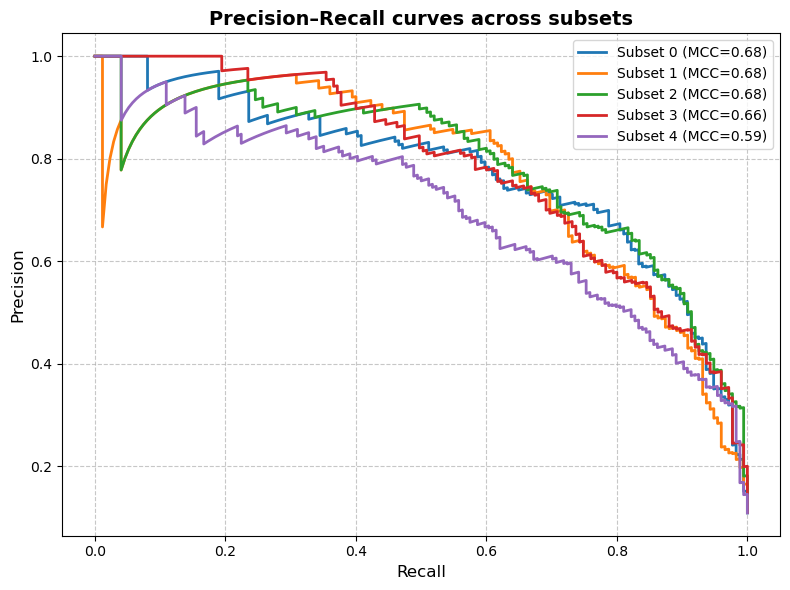

In [202]:
# dizionari dove c'hai i risultati
final_score_test = {}
y_pred_test = {}
y_true_test = {}
mcc_dict = {}

# --- loop per ogni subset ---
for i in range(5):
    print(f"\nSubset {i}")
    matrix = PSWM_matrix_final[f'PSWM_matrix{i}']
    threshold = optimal_threshold[f'optimal_threshold{i}']
    testing_set = testingset[i]
    labels_test = list_labels[i]

    # funzione testing
    final_score, y_pred = testing(matrix, threshold, testing_set)
    final_score_test[f'final_score_test_{i}'] = final_score
    y_pred_test[f'y_pred_test_{i}'] = y_pred
    y_true_test[f'y_true_test_{i}'] = labels_test

    # metriche
    mcc = matthews_corrcoef(labels_test, y_pred)
    prec = precision_score(labels_test, y_pred)
    acc = accuracy_score(labels_test, y_pred)
    sens = recall_score(labels_test, y_pred)
    cm = confusion_matrix(labels_test, y_pred)
    mcc_dict[i] = mcc

    print(f"MCC = {mcc:.3f}")
    print(f"Precision = {prec:.3f}")
    print(f"Accuracy = {acc:.3f}")
    print(f"Sensitivity = {sens:.3f}")
    print("Confusion Matrix:\n", cm)

    # --- HEATMAP DARK ---
    plt.style.use("dark_background")
    df_matrix = pd.DataFrame(matrix).T
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        df_matrix,
        annot=True,
        fmt=".2f",
        cmap="magma",
        center=0,
        linewidths=0.4,
        linecolor='gray',
        annot_kws={"size": 8, "color": "white", "weight": "bold"},
        cbar_kws={'label': 'Log2-Frequency'}
    )
    plt.title(f"Heatmap PSWM Matrix {i}", fontsize=16, fontweight="bold", pad=15, color="white")
    plt.xlabel("Position", fontsize=12, labelpad=8, color="white")
    plt.ylabel("Amino Acid", fontsize=12, labelpad=8, color="white")
    plt.xticks(fontsize=10, rotation=0, color="white")
    plt.yticks(fontsize=10, color="white")
    plt.tight_layout()
    plt.savefig(f"./Plots/heatmap_pswm_matrix_{i}_dark.png", dpi=300, bbox_inches="tight")
    plt.close()
    plt.style.use("default")  # torniamo al tema bianco per il resto

    # --- CURVA PR (NORMALE) ---
    prec_curve, rec_curve, thr_curve = precision_recall_curve(labels_test, final_score)
    plt.figure(figsize=(6, 5))
    plt.plot(rec_curve, prec_curve, label="PR curve", color="royalblue", linewidth=2)
    best_thr_idx = min(range(len(thr_curve)), key=lambda j: abs(thr_curve[j] - threshold))
    plt.scatter(
        rec_curve[best_thr_idx],
        prec_curve[best_thr_idx],
        color='red', s=80, label=f"Best thr = {threshold:.3f}"
    )
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision–Recall curve with best threshold")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.savefig(f"./Plots/pr_curve_subset_{i}.png", dpi=300)
    plt.close()

# --- GRAFICO CUMULATIVO PR (NORMALE) ---
plt.figure(figsize=(8, 6))
for i in range(5):
    labels_test = y_true_test[f'y_true_test_{i}']
    final_score = final_score_test[f'final_score_test_{i}']
    prec_curve, rec_curve, _ = precision_recall_curve(labels_test, final_score)
    plt.plot(rec_curve, prec_curve, label=f"Subset {i} (MCC={mcc_dict[i]:.2f})", linewidth=2)

plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Precision–Recall curves across subsets", fontsize=14, fontweight="bold")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("./Plots/all_pr_curves.png", dpi=300)
plt.show()
